In [1]:
import os, pandas as pd, numpy as np, gmsPython, pyDatabases

*Settings for plots:*

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt, seaborn
from matplotlib import cm
from matplotlib.ticker import LinearLocator
pd.options.plotting.backend = 'matplotlib'
%matplotlib inline
plt.style.use('seaborn-whitegrid')
mpl.style.use('seaborn')
plt.rcParams['font.family'] = 'Palatino Linotype'
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
long_colors = ['#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

# The basic approach

The basic approach uses GAMS code and GDX input data. ```gmsPython``` and ```pyDatabases``` are used to execute the GAMS model, retrieve the data, create plots, and potentially loop over the model.

When we refer to GAMS Python objects, you can find some documentation here: https://www.gams.com/latest/docs/API_PY_TUTORIAL.html, https://www.gams.com/latest/docs/apis/python/annotated.html.

## Example 1: Run GAMS model using ```gmsPython```

The file "*smallGR_baseline.gms*" specifies a general equilibrium model with four sectors: energy, waste, other1, and other2. It uses input data from "*smallGR_GE.gdx*". The first example uses the class ```GmsModel``` from ```gmsPython``` to run GAMS models from Python and access the output from Python.

In [3]:
from gmsPython import GmsModel

The ```GmsModel``` class takes three inputs:

```python
    class GmsModel:
        def __init__(self, ws = None, options = None, **kwargs)            
```

* The ```ws``` argument specifies where the gams model should be run from. We can add a ```gams.GamsWorkspace``` (a gams object) or specify what directory to use.
* The ```options``` argument is used to specify the options ```gams.GamsOptions``` (a gams object). This is added as a python ```dictionary```.

*Example: Start ```GmsModel``` from the directory 'work_folder' and add that CNS models should be solved with CONOPT4:*

In [4]:
m = GmsModel(ws = os.path.join(os.getcwd(), 'work_folder'), options = {'cns': 'CONOPT4'})

If we load the text from the gams model into a ```string```, we can see that the code includes the GAMS-feature of a placeholder "%rname%":

In [5]:
with open(os.path.join(os.getcwd(), 'smallGR_baseline.gms'), "r") as file:
    modelText = file.read()
print(modelText)

$ONEOLCOM
$EOLCOM #
;
OPTION SYSOUT=OFF, SOLPRINT=OFF, LIMROW=0, LIMCOL=0, DECIMALS=6;


# ----------------------------------------------------------------------------------------------------
#  Define function: SolveEmptyNLP
# ----------------------------------------------------------------------------------------------------

sets
	alias_set
	alias_map2
	t
	n
	s
	a
	taxTypes
;

alias(n,nn,nnn);
alias(s,ss);

sets
	alias_[alias_set,alias_map2]
	t0[t]
	tE[t]
	t2E[t]
	tx0[t]
	txE[t]
	tx2E[t]
	tx0E[t]
	tx02E[t]
	map_smallGR_G[s,n,nn]
	map_spinp_smallGR_G[s,n,nn]
	map_spout_smallGR_G[s,n,nn]
	knout_smallGR_G[s,n]
	kninp_smallGR_G[s,n]
	spout_smallGR_G[s,n]
	spinp_smallGR_G[s,n]
	input_smallGR_G[s,n]
	output_smallGR_G[s,n]
	int_smallGR_G[s,n]
	map_gc[s,n,nn]
	knot_gc[s,n]
	branch_gc[s,n]
	knot_o_gc[s,n]
	knot_no_gc[s,n]
	branch2o_gc[s,n]
	branch2no_gc[s,n]
	endo_mu_smallGR_G[s,n,nn]
	input_n_smallGR_G[n]
	s_smallGR_G[s]
	labor[s,n]
	d_TotalTax[s]
	map_smallGR_HH[s,n,nn]
	map_spinp_smallGR_

We use the method ```addlocal``` to tell GAMS that whenever it reads "rname" it should replace it with the path for the data file "smallGR_GE.gdx":

In [6]:
m.addlocal("rname", os.path.join(os.getcwd(), 'smallGR_GE.gdx')) # replace 'rname' with the file location

The simplest way to run the model is to use the ```self.run``` method. For this to work, we simply have to provide the GAMS code that specifies the model. We can either give as a ```string``` or point to the file that specifies the model.

In [7]:
m.run(runfile = os.path.join(os.getcwd(), 'smallGR_baseline.gms')) # run from file

The solution is automatically loaded as a ```GpyDB``` database (from ```pyDatabases```) and stored as ```self.out_db```, allowing us to inspect/adjust/plot results directly here:

In [8]:
m.out_db.symbols # get a list of all symbols in the database

{'alias_set': <pyDatabases.gpyDB._database.gpy at 0x28014ce48b0>,
 'alias_map2': <pyDatabases.gpyDB._database.gpy at 0x28014c2b850>,
 't': <pyDatabases.gpyDB._database.gpy at 0x28014ce4490>,
 'n': <pyDatabases.gpyDB._database.gpy at 0x28014ce4670>,
 's': <pyDatabases.gpyDB._database.gpy at 0x28014ce45e0>,
 'a': <pyDatabases.gpyDB._database.gpy at 0x28014ce4730>,
 'taxTypes': <pyDatabases.gpyDB._database.gpy at 0x28014ce47f0>,
 'alias_': <pyDatabases.gpyDB._database.gpy at 0x28015fcaee0>,
 't0': <pyDatabases.gpyDB._database.gpy at 0x28014ce4a90>,
 'tE': <pyDatabases.gpyDB._database.gpy at 0x28014ce4b20>,
 't2E': <pyDatabases.gpyDB._database.gpy at 0x28014ce4be0>,
 'tx0': <pyDatabases.gpyDB._database.gpy at 0x28014ce4ca0>,
 'txE': <pyDatabases.gpyDB._database.gpy at 0x28014ce4d60>,
 'tx2E': <pyDatabases.gpyDB._database.gpy at 0x28014ce4e20>,
 'tx0E': <pyDatabases.gpyDB._database.gpy at 0x28014ce4ee0>,
 'tx02E': <pyDatabases.gpyDB._database.gpy at 0x28014ce4fa0>,
 'map_smallGR_G': <pyData

In [9]:
m.out_db.get('qD') # access the variable 'qD' 

t     s     n       
2018  I_iK  energy       0.080006
            o1Agg       11.978649
            o2Agg       31.121667
            other1       5.346214
            other1_F     6.822543
                          ...    
2050  HH    C                 0.5
            eAgg         2.855419
            o1Agg        13.43628
            o2Agg       68.588124
            wAgg         0.504333
Name: level, Length: 3508, dtype: object

<AxesSubplot:xlabel='t'>

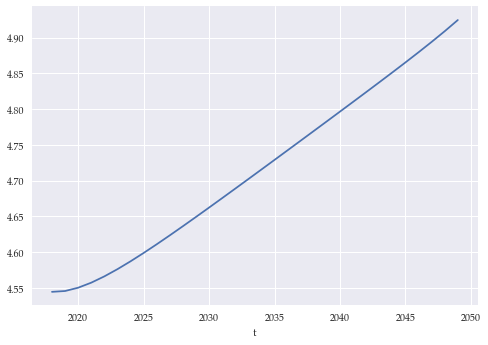

In [10]:
m.out_db.get('qD').xs(('HH','other1'), level = ['s','n']).plot(backend='matplotlib') # Plot households' demand for 'other1' over time; this uses standard 'pandas' methods

## Example 2: Run and loop

In this example we run the model, store a ```gams.execution.GamsCheckPoint```, add some new text, and run from that checkpoint again. After the initial "manual" exercise, we show how this can be used to do some simple loops.

### Store and re-run from checkpoint

*Start a new instance of a model with the same settings as example 1:*

In [11]:
m = GmsModel(ws = os.path.join(os.getcwd(), 'work_folder'), options = {'cns': 'CONOPT4'})

*Use addlocal to point to the data again:*

In [12]:
m.addlocal("rname", os.path.join(os.getcwd(), 'smallGR_GE.gdx')) # replace 'rname' with the file location

*This time, instead of using the run method with only the gams model as input, we start by specifying a ```GamsCheckpoint``` and add this to the run statement:*

In [13]:
checkpoint = m.ws.add_checkpoint() # gams object
m.run(runfile = os.path.join(os.getcwd(), 'smallGR_baseline.gms'), options_run = {'checkpoint': checkpoint}) # run from file, add the checkpoint in the run statement to be stored after running the model

*We can still access the solution from the ```self.out_db```, but we can also choose to re-run, starting from this checkpoint:*

In [14]:
qD0 = m.out_db.get('qD') # get first solution
textShock = "p.fx[t,'energy_F'] = 2; solve smallGR_GE_B using CNS;" # double price on foreign energy permanently
m.run(run = textShock, options_add = {'checkpoint': checkpoint}) # implement textShock and run the model starting from the checkpoint

*We can now compare the quantities from before and after the shock; here we plot a part of the data:*

In [15]:
qD1 = m.out_db.get('qD')
pd.DataFrame({'Before': qD0, 'After': qD1})

Before      After
t    s    n                             
2018 I_iK energy     0.080006   0.083263
          o1Agg     11.978649   15.90766
          o2Agg     31.121667  40.642688
          other1     5.346214   6.920394
          other1_F   6.822543   9.241777
...                       ...        ...
2050 HH   C               0.5        0.5
          eAgg       2.855419   2.855419
          o1Agg      13.43628   13.43628
          o2Agg     68.588124  68.588124
          wAgg       0.504333   0.504333

[3508 rows x 2 columns]

### Loop with checkpoints:

*Using the checkpoint approach, we can loop over different shocks and extract the solution for each one of them:*

In [16]:
shockValues = np.linspace(1,2,11) # linear grid from 1 to 2 with 11 steps.
newCheckpoint = m.ws.add_checkpoint() # new checkpoint
solution = {} # empty dictionary to store solution in
for i in range(len(shockValues)): # loop over values
    textShock = f"p.fx[t,'energy_F'] = {shockValues[i]}; solve smallGR_GE_B using CNS;" # update text with new values
    # start from checkpoint in the first loop, otherwise start from newCheckpoint. When the model is solved, save the new solution in the newCheckpoint:
    m.run(run = textShock, options_add = {'checkpoint': checkpoint if i == 0 else newCheckpoint}, options_run = {'checkpoint': newCheckpoint}) 
    solution[i] = m.out_db.get('qD') # store solution

*NB: This shows how to loop with checkpoints along the way. The ```gmsWrite``` class has a automatic version that is much more efficient that runs using gams code.*

*Collect the solution in one dataframe:*

In [21]:
pd.DataFrame({f"$p=${np.round(shockValues[i],1)}": solution[i] for i in range(len(shockValues))})

$p=$1.0    $p=$1.1    $p=$1.2    $p=$1.3    $p=$1.4  \
t    s    n                                                                 
2018 I_iK energy     0.080006   0.079213   0.078626    0.07829   0.078223   
          o1Agg     11.978649   12.12283  12.319609  12.570788  12.877211   
          o2Agg     31.121667  31.479482   31.96772  32.589799  33.346312   
          other1     5.346214   5.405204   5.485924   5.588998   5.714513   
          other1_F   6.822543   6.910024   7.029217   7.181333    7.36715   
...                       ...        ...        ...        ...        ...   
2050 HH   C               0.5        0.5        0.5        0.5        0.5   
          eAgg       2.855419   2.855419   2.855419   2.855419   2.855419   
          o1Agg      13.43628   13.43628   13.43628   13.43628   13.43628   
          o2Agg     68.588124  68.588124  68.588124  68.588124  68.588124   
          wAgg       0.504333   0.504333   0.504333   0.504333   0.504333   

                      $p=$1.5    $p=$1.6    $p=$1.7    $p=$1.8    $p=$1.9  \
t    s    n                                                                 
2018 I_iK energy     0.078432   0.078911   0.079649   0.080634   0.081846   
          o1Agg      13.23934  13.657633  14.132721  14.665439  15.256764   
          o2Agg     34.236455  35.258935  36.412378  37.695368  39.106236   
          other1     5.862265   6.031918    6.22307   6.435264   6.667945   
          other1_F   7.587356   7.842769   8.134454   8.463758   8.832274   
...                       ...        ...        ...        ...        ...   
2050 HH   C               0.5        0.5        0.5        0.5        0.5   
          eAgg       2.855419   2.855419   2.855419   2.855419   2.855419   
          o1Agg      13.43628   13.43628   13.43628   13.43628   13.43628   
          o2Agg     68.588124  68.588124  68.588124  68.588124  68.588124   
          wAgg       0.504333   0.504333   0.504333   0.504333   0.504333   

                      $p=$2.0  
t    s    n                    
2018 I_iK energy     0.083263  
          o1Agg      15.90766  
          o2Agg     40.642688  
          other1     6.920394  
          other1_F   9.241777  
...                       ...  
2050 HH   C               0.5  
          eAgg       2.855419  
          o1Agg      13.43628  
          o2Agg     68.588124  
          wAgg       0.504333  

[3508 rows x 11 columns]